In [228]:
import pandas as pd
import numpy as np

consDF = pd.read_parquet("data/Consumer.pqt")
consDF = consDF.drop(columns = ["credit_score"])
testDF = consDF[consDF['DQ_TARGET'].isna()]
consDF = consDF.dropna()
acctDF = pd.read_parquet("data/Account.pqt")
acctDF = acctDF[acctDF["prism_consumer_id"].isin(consDF['prism_consumer_id'])]
trxnDF = pd.read_parquet("data/Transaction.pqt")
trxnDF = trxnDF[trxnDF["prism_consumer_id"].isin(consDF['prism_consumer_id'])]
catmap = pd.read_csv("data/catmap.csv")
trxnDF = trxnDF.drop_duplicates()



In [229]:
acctDF['balance_date'] = pd.to_datetime(acctDF['balance_date'])

date_spread = acctDF.groupby('prism_consumer_id')['balance_date'].agg(
    earliest_balance='min',
    latest_balance='max',
    account_count='count'
).reset_index()

date_spread['days_spread'] = (
    date_spread['latest_balance'] - date_spread['earliest_balance']
).dt.days

perfect_consumers = date_spread[date_spread['days_spread'] == 0]

minor_drift = date_spread[
    (date_spread['days_spread'] > 0) & 
    (date_spread['days_spread'] <= 2)
]

bad_consumers = date_spread[date_spread['days_spread'] > 2].sort_values('days_spread', ascending=False)
good_balance = date_spread[(date_spread['days_spread'] <= 2)]["prism_consumer_id"]
print(f"--- SANITY CHECK SUMMARY ---")
print(f"Total Consumers: {len(date_spread)}")
print(f"Perfectly Aligned (0 days spread): {len(perfect_consumers)} ({len(perfect_consumers)/len(date_spread):.1%})")
print(f"Minor Drift (1-2 days): {len(minor_drift)}")
print(f"Major Disconnect (>2 days): {len(bad_consumers)}")

print("\n--- WORST OFFENDERS (Largest Gaps) ---")
print(bad_consumers.head(10))


--- SANITY CHECK SUMMARY ---
Total Consumers: 10408
Perfectly Aligned (0 days spread): 10146 (97.5%)
Minor Drift (1-2 days): 20
Major Disconnect (>2 days): 242

--- WORST OFFENDERS (Largest Gaps) ---
      prism_consumer_id earliest_balance latest_balance  account_count  \
3048               1443       2021-03-01     2023-01-31              2   
3                   100       2021-04-30     2022-12-31              2   
7150                609       2021-06-30     2023-02-28              2   
10356               952       2021-07-31     2023-02-28              3   
5085               3302       2021-07-31     2023-01-31              2   
3232               1612       2021-09-30     2023-01-31              2   
4678               2935       2021-09-29     2022-11-30              2   
3474               1834       2021-12-31     2023-01-31              2   
4762                301       2021-04-30     2022-04-30              2   
9435                820       2021-04-16     2022-03-28     

In [230]:
acctDF['balance_date'] = pd.to_datetime(acctDF['balance_date'])
trxnDF['posted_date'] = pd.to_datetime(trxnDF['posted_date'])

trxnDF = trxnDF[trxnDF['prism_consumer_id'].isin(good_balance)]
acctDF = acctDF[acctDF['prism_consumer_id'].isin(good_balance)]

consumer_snapshot = acctDF.groupby(['prism_consumer_id', 'balance_date'])['balance'].sum().reset_index()
consumer_snapshot = consumer_snapshot.rename(columns={'balance': 'snapshot_balance', 'balance_date': 'snapshot_date'})

trxnDF['signed_amount'] = np.where(
    trxnDF['credit_or_debit'] == 'DEBIT', 
    -trxnDF['amount'], 
    trxnDF['amount']
)

trxnDF = trxnDF.sort_values(['prism_consumer_id', 'posted_date', 'prism_transaction_id'])

trxnDF['raw_cumsum'] = trxnDF.groupby('prism_consumer_id')['signed_amount'].cumsum()

df_merged = trxnDF.merge(consumer_snapshot, on='prism_consumer_id', how='left')

anchor_points = df_merged[df_merged['posted_date'] <= df_merged['snapshot_date']].sort_values(['prism_consumer_id', 'posted_date', 'prism_transaction_id'])
anchor_points = anchor_points.groupby('prism_consumer_id').last()[['raw_cumsum']].reset_index()
anchor_points = anchor_points.rename(columns={'raw_cumsum': 'cumsum_at_snapshot'})

df_merged = df_merged.merge(anchor_points, on='prism_consumer_id', how='left')

# ---------------------------------------------------------
# FINAL CALCULATION
# ---------------------------------------------------------

# Apply the offset formula
# This works for both Past (backward fill) and Future (forward fill) automatically.
df_merged['running_balance'] = (
    df_merged['raw_cumsum'] - df_merged['cumsum_at_snapshot']
) + df_merged['snapshot_balance']

# Final Cleanup: Select relevant columns for your history view
history_df = df_merged[[
    'prism_consumer_id', 
    'posted_date', 
    'category', 
    'amount', 
    'credit_or_debit', 
    'running_balance' # This is your history of changes
]]

history_df

,prism_consumer_id,posted_date,category,amount,credit_or_debit,running_balance
0,0,2021-03-16,14,27.62,DEBIT,1347.62
1,0,2021-03-17,11,1400.00,CREDIT,2747.62
2,0,2021-03-17,39,25.10,DEBIT,2722.52
3,0,2021-03-17,37,500.00,DEBIT,2222.52
4,0,2021-03-18,14,25.00,DEBIT,2197.52
...,...,...,...,...,...,...
4106777,999,2021-03-11,16,30.00,DEBIT,484.31
4106778,999,2021-03-12,19,20.00,DEBIT,464.31
4106779,999,2021-03-12,14,4.16,DEBIT,460.15
4106780,999,2021-03-12,4,63.00,DEBIT,397.15


In [33]:
A = history_df[history_df["prism_consumer_id"]== "0"]
A.loc[A["posted_date"] == "2021-08-31"]

,prism_consumer_id,posted_date,category,amount,credit_or_debit,running_balance
375,0,2021-08-31,1,49.25,CREDIT,452.44
376,0,2021-08-31,16,72.40,DEBIT,380.04
377,0,2021-08-31,14,20.00,DEBIT,360.04
378,0,2021-08-31,16,32.67,DEBIT,327.37
379,0,2021-08-31,14,7.00,DEBIT,320.37


In [ ]:
acctDF[acctDF['prism_consumer_id'] == '0']["balance"].sum()

np.float64(320.37)

In [50]:
neg_list = consDF[consDF["DQ_TARGET"] == 0]["prism_consumer_id"]
pos_list = consDF[consDF["DQ_TARGET"] == 1]["prism_consumer_id"]

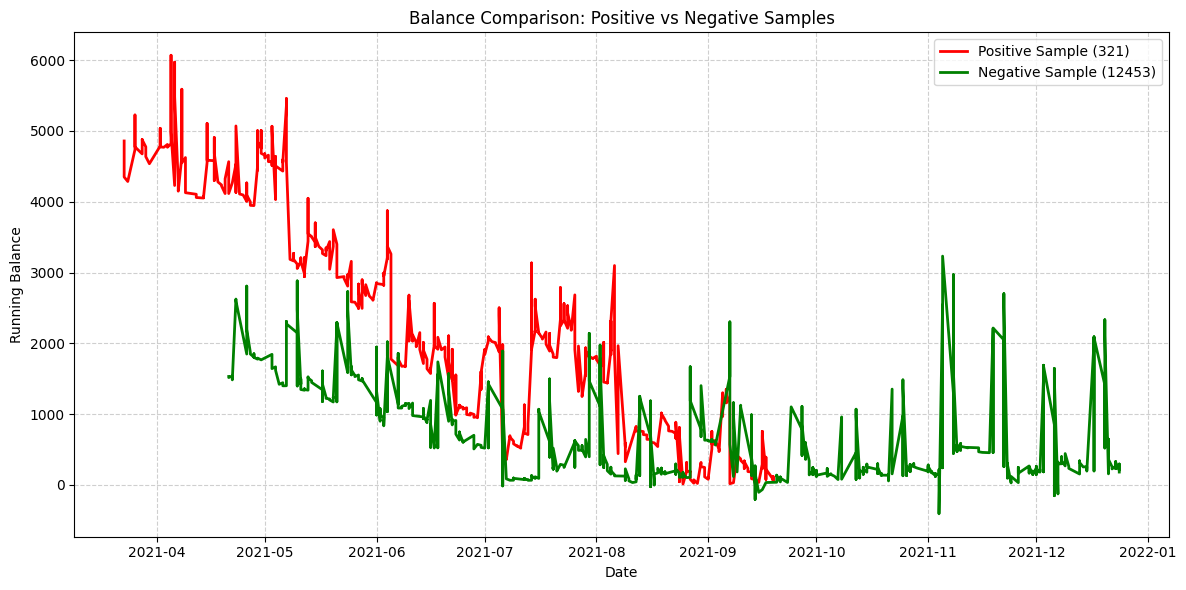

In [ ]:
import matplotlib.pyplot as plt

neg_id = neg_list.sample(1).iloc[0]
pos_id = pos_list.sample(1).iloc[0]

df_neg = history_df[history_df["prism_consumer_id"] == neg_id].copy()
df_pos = history_df[history_df["prism_consumer_id"] == pos_id].copy()

df_neg["posted_date"] = pd.to_datetime(df_neg["posted_date"])
df_pos["posted_date"] = pd.to_datetime(df_pos["posted_date"])

df_neg = df_neg.sort_values("posted_date")
df_pos = df_pos.sort_values("posted_date")

plt.figure(figsize=(12, 6))

plt.plot(df_pos["posted_date"], df_pos["running_balance"], 
         color="red", label=f"Positive Sample ({pos_id})", linewidth=2)

plt.plot(df_neg["posted_date"], df_neg["running_balance"], 
         color="green", label=f"Negative Sample ({neg_id})", linewidth=2)

plt.title("Balance Comparison: Positive vs Negative Samples")
plt.xlabel("Date")
plt.ylabel("Running Balance")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

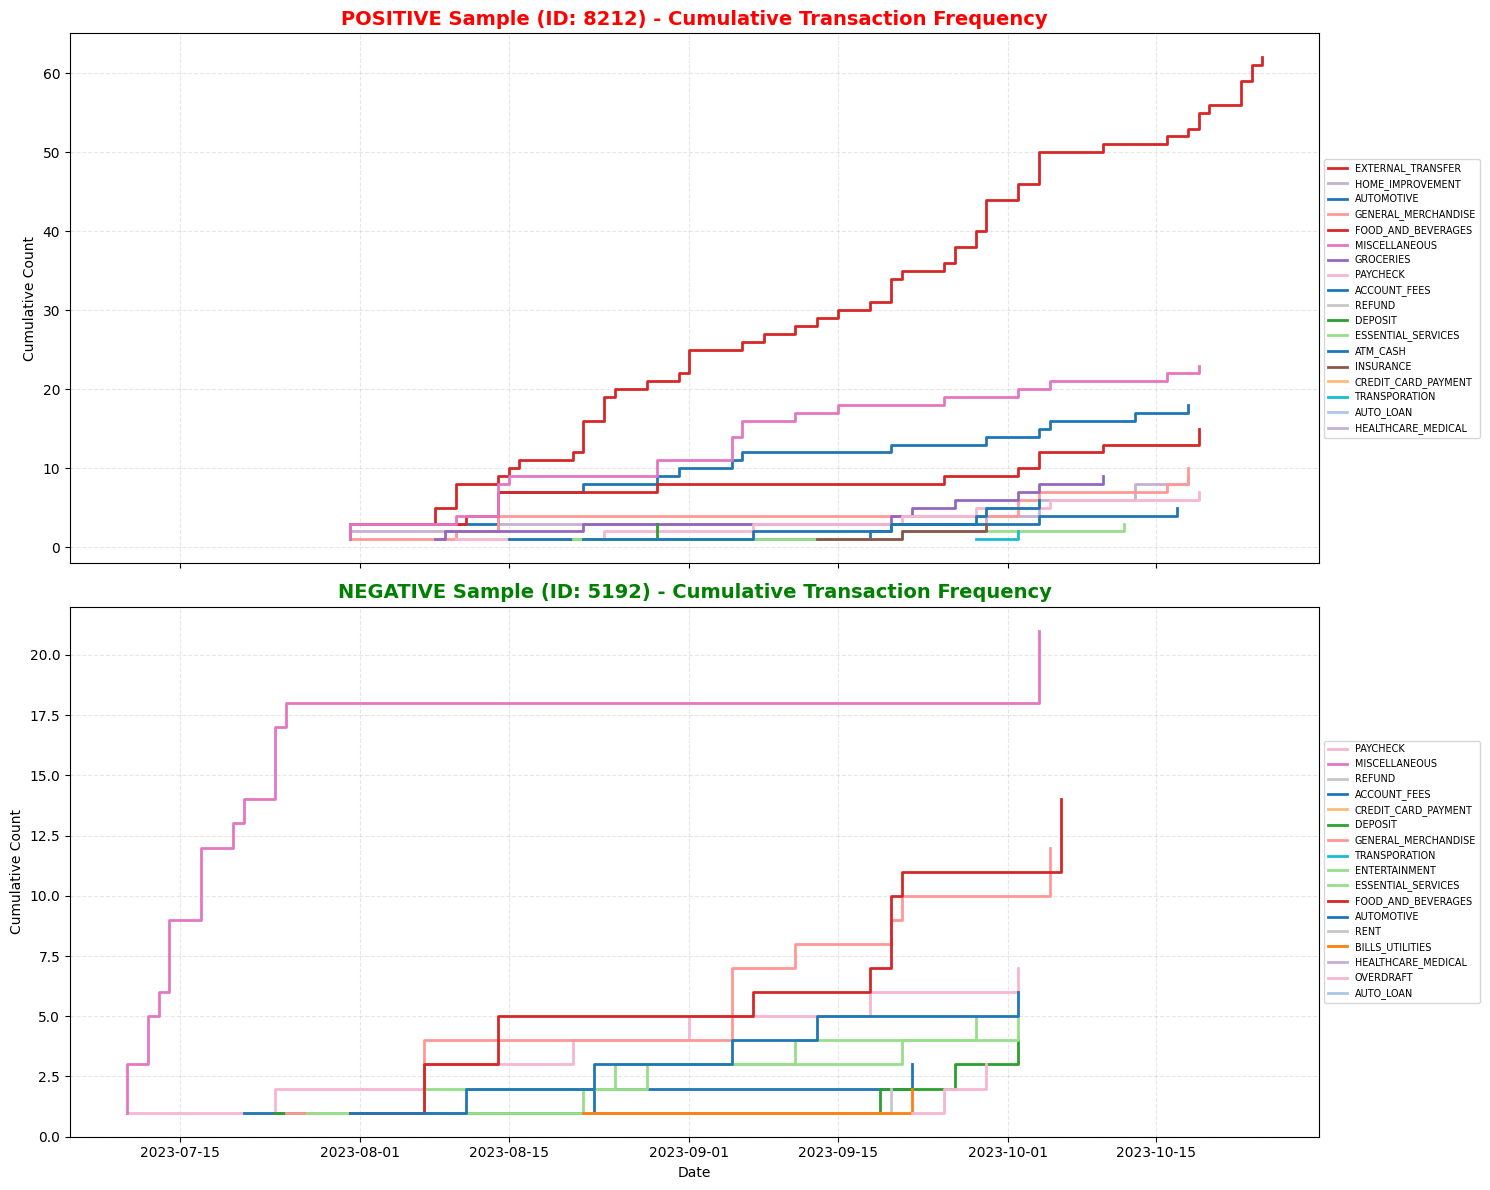

In [ ]:

unique_categories = sorted(catmap['category'].unique())
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_categories)))
color_map = dict(zip(unique_categories, colors))
cat_dict = dict(zip(catmap['category_id'].astype(str), catmap['category']))

def process_frequency_data(df, consumer_id):
    subset = df[df["prism_consumer_id"] == str(consumer_id)].copy()
    subset["posted_date"] = pd.to_datetime(subset["posted_date"])
    subset = subset.sort_values("posted_date")
    subset['category_name'] = subset['category'].astype(str).map(cat_dict)
    
    # We create a counter and calculate the running total of occurrences
    subset['occurrence'] = 1
    subset['cum_frequency'] = subset.groupby('category_name')['occurrence'].cumsum()
    return subset

# 2. Select samples (Red for Positive, Green for Negative titles)
pos_id = pos_list.sample(1).iloc[0]
neg_id = neg_list.sample(1).iloc[0]

df_pos_freq = process_frequency_data(history_df, pos_id)
df_neg_freq = process_frequency_data(history_df, neg_id)

# 3. Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Plot Positive Sample
for cat in df_pos_freq['category_name'].unique():
    data = df_pos_freq[df_pos_freq['category_name'] == cat]
    ax1.step(data['posted_date'], data['cum_frequency'], 
             label=cat, where='post', color=color_map[cat], linewidth=2)

ax1.set_title(f"POSITIVE Sample (ID: {pos_id}) - Cumulative Transaction Frequency", 
              fontsize=14, color='red', fontweight='bold')
ax1.set_ylabel("Cumulative Count")
ax1.grid(True, linestyle='--', alpha=0.3)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize='x-small')

# Plot Negative Sample
for cat in df_neg_freq['category_name'].unique():
    data = df_neg_freq[df_neg_freq['category_name'] == cat]
    ax2.step(data['posted_date'], data['cum_frequency'], 
             label=cat, where='post', color=color_map[cat], linewidth=2)

ax2.set_title(f"NEGATIVE Sample (ID: {neg_id}) - Cumulative Transaction Frequency", 
              fontsize=14, color='green', fontweight='bold')
ax2.set_ylabel("Cumulative Count")
ax2.set_xlabel("Date")
ax2.grid(True, linestyle='--', alpha=0.3)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize='x-small')

plt.tight_layout()
plt.show()

In [143]:

debit_categories = set(trxnDF[trxnDF["credit_or_debit"] == "DEBIT"]["category"].unique().astype(str))

credit_categories = set(trxnDF[trxnDF["credit_or_debit"] == "CREDIT"]["category"].unique().astype(str))

strict_income_ids = list(credit_categories - debit_categories)

strict_income_names = {i: cat_dict[i] for i in strict_income_ids if i in cat_dict}

print("Strictly Income Categories:")
for cid, name in strict_income_names.items():
    print(f"ID {cid}: {name}")

Strictly Income Categories:
ID 2: DEPOSIT
ID 6: REFUND
ID 48: TIME_OR_STUFF
ID 3: PAYCHECK
ID 7: INVESTMENT_INCOME
ID 49: PENSION
ID 9: UNEMPLOYMENT_BENEFITS
ID 8: OTHER_BENEFITS


/var/folders/6r/152n25q91lzcqtjmm1gt04vc0000gn/T/ipykernel_48570/1160651764.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_df = features.groupby(['status', 'steadiness_level']).size().unstack(fill_value=0)


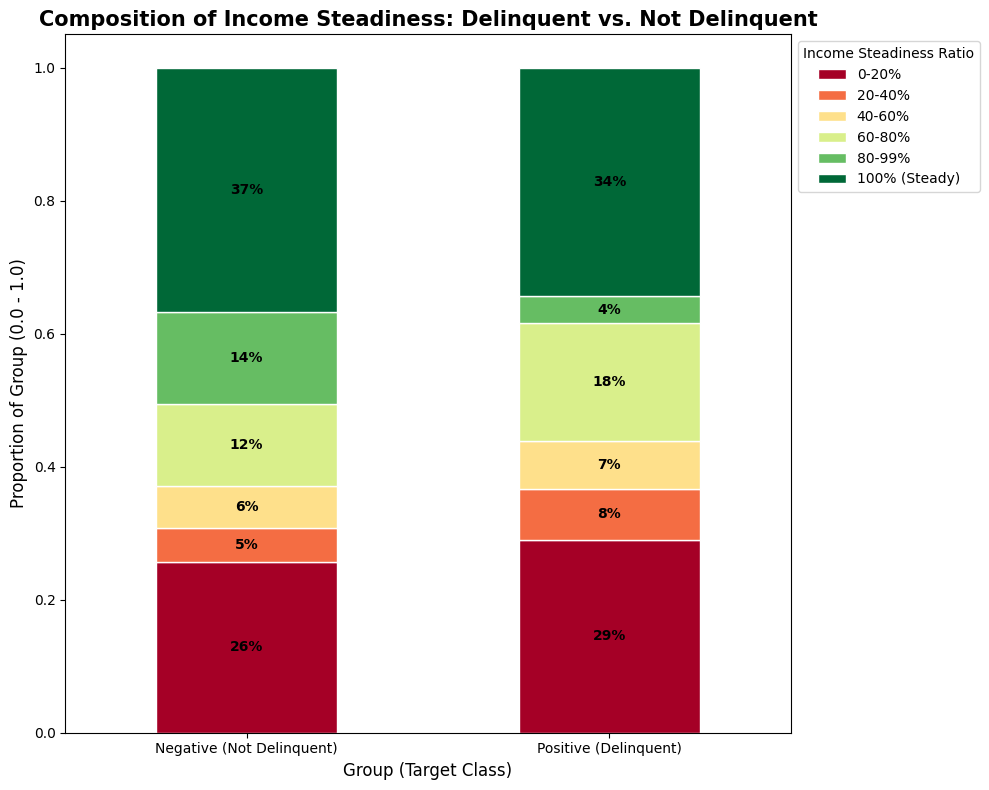

In [ ]:
target_cats = ["3", "9", "49"]
df = history_df.copy()
df['posted_date'] = pd.to_datetime(df['posted_date'])
df['year_month'] = df['posted_date'].dt.to_period('M')

expected = df.groupby('prism_consumer_id')['year_month'].nunique()
income_df = df[df['category'].astype(str).isin(target_cats)]
actual = income_df.groupby('prism_consumer_id')['year_month'].nunique()

features = pd.DataFrame({'ratio': actual / expected}).fillna(0)

features['status'] = 'Other'
features.loc[features.index.isin(neg_list.astype(str)), 'status'] = 'Negative (Not Delinquent)'
features.loc[features.index.isin(pos_list.astype(str)), 'status'] = 'Positive (Delinquent)'
features = features[features['status'] != 'Other']

bins = [0, 0.2, 0.4, 0.6, 0.8, 0.99, 1.0]
labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-99%', '100% (Steady)']
features['steadiness_level'] = pd.cut(features['ratio'], bins=bins, labels=labels, include_lowest=True)

pivot_df = features.groupby(['status', 'steadiness_level']).size().unstack(fill_value=0)

pivot_norm = pivot_df.div(pivot_df.sum(axis=1), axis=0)

ax = pivot_norm.plot(kind='bar', stacked=True, figsize=(10, 8), colormap='RdYlGn', edgecolor='white')

plt.title('Composition of Income Steadiness: Delinquent vs. Not Delinquent', fontsize=15, fontweight='bold')
plt.xlabel('Group (Target Class)', fontsize=12)
plt.ylabel('Proportion of Group (0.0 - 1.0)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Income Steadiness Ratio", loc='upper left', bbox_to_anchor=(1, 1))

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    if height > 0.03:
        x, y = p.get_xy() 
        ax.text(x + width/2, y + height/2, f'{height:.0%}', 
                ha='center', va='center', color='black', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [173]:
trxnDF

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,signed_amount,raw_cumsum
136802,0,136738,14,27.62,DEBIT,2021-03-16,-27.62,-27.62
136767,0,136703,11,1400.00,CREDIT,2021-03-17,1400.00,1372.38
136803,0,136739,39,25.10,DEBIT,2021-03-17,-25.10,1347.28
136804,0,136740,37,500.00,DEBIT,2021-03-17,-500.00,847.28
136805,0,136741,14,25.00,DEBIT,2021-03-18,-25.00,822.28
...,...,...,...,...,...,...,...,...
981350,999,980640,16,30.00,DEBIT,2021-03-11,-30.00,113.29
981351,999,980641,19,20.00,DEBIT,2021-03-12,-20.00,93.29
981352,999,980642,14,4.16,DEBIT,2021-03-12,-4.16,89.13
981353,999,980643,4,63.00,DEBIT,2021-03-12,-63.00,26.13


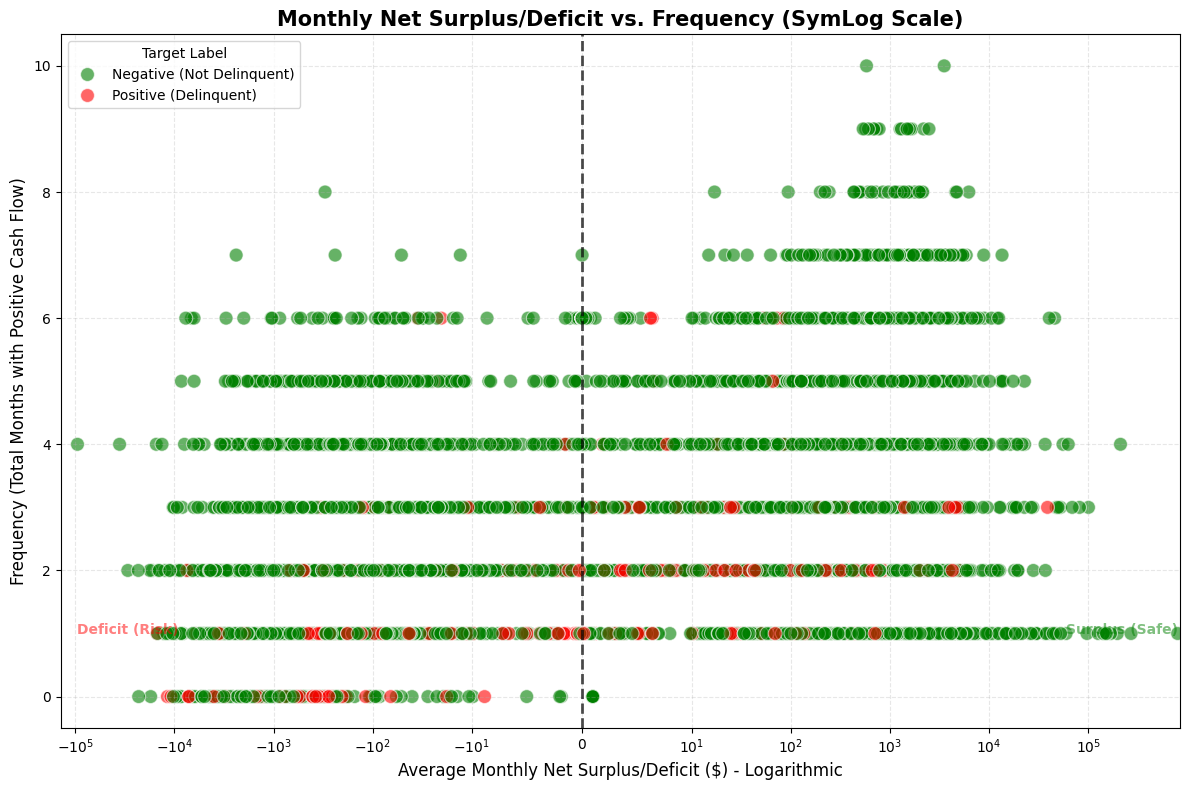

In [179]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def analyze_full_cashflow(df, pos_list, neg_list):
    df = df.copy()
    df['posted_date'] = pd.to_datetime(df['posted_date'])
    df['year_month'] = df['posted_date'].dt.to_period('M')
    
    # 1. Calculate Monthly Net Cash Flow using signed_amount
    monthly_cashflow = df.groupby(['prism_consumer_id', 'year_month'])['signed_amount'].sum().reset_index()
    
    # 2. Aggregate per Consumer
    stats = monthly_cashflow.groupby('prism_consumer_id').agg(
        leftover_frequency=('signed_amount', lambda x: (x > 0).sum()),
        avg_net_amount=('signed_amount', 'mean') 
    ).reset_index()
    
    # Handle Net 0: If amount is exactly 0, we treat it as 1 to keep it on the positive side of log
    # or to ensure it is visible in the symlog plot.
    stats['avg_net_amount'] = stats['avg_net_amount'].apply(lambda x: x + 1 if x == 0 else x)
    
    # 3. Assign Target Labels
    stats['status'] = 'Other'
    stats.loc[stats['prism_consumer_id'].astype(str).isin(neg_list.astype(str)), 'status'] = 'Negative (Not Delinquent)'
    stats.loc[stats['prism_consumer_id'].astype(str).isin(pos_list.astype(str)), 'status'] = 'Positive (Delinquent)'
    
    return stats[stats['status'] != 'Other']

# Generate metrics
cashflow_stats = analyze_full_cashflow(trxnDF, pos_list, neg_list)

# 4. Visualization (Symmetric Log Scale)
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=cashflow_stats,
    x='avg_net_amount',       
    y='leftover_frequency',   
    hue='status',
    palette={'Negative (Not Delinquent)': 'green', 'Positive (Delinquent)': 'red'},
    alpha=0.6,
    s=100,
    edgecolor='w'
)

# --- Apply Symmetric Log Scale ---
# linthresh=10 defines the range (-10 to 10) that remains linear
plt.xscale('symlog', linthresh=10)

# Add a vertical line at 0 (or technically at 1 if we shifted 0s)
plt.axvline(0, color='black', linestyle='--', linewidth=2, alpha=0.7)

# Add annotations for clarity
plt.text(cashflow_stats['avg_net_amount'].min(), 1, "Deficit (Risk)", color='red', alpha=0.5, fontweight='bold')
plt.text(cashflow_stats['avg_net_amount'].max(), 1, "Surplus (Safe)", color='green', alpha=0.5, fontweight='bold', ha='right')

plt.title('Monthly Net Surplus/Deficit vs. Frequency (SymLog Scale)', fontsize=15, fontweight='bold')
plt.xlabel('Average Monthly Net Surplus/Deficit ($) - Logarithmic', fontsize=12)
plt.ylabel('Frequency (Total Months with Positive Cash Flow)', fontsize=12)
plt.grid(True, which="both", linestyle='--', alpha=0.3)
plt.legend(title='Target Label', loc='upper left')

plt.tight_layout()
plt.show()

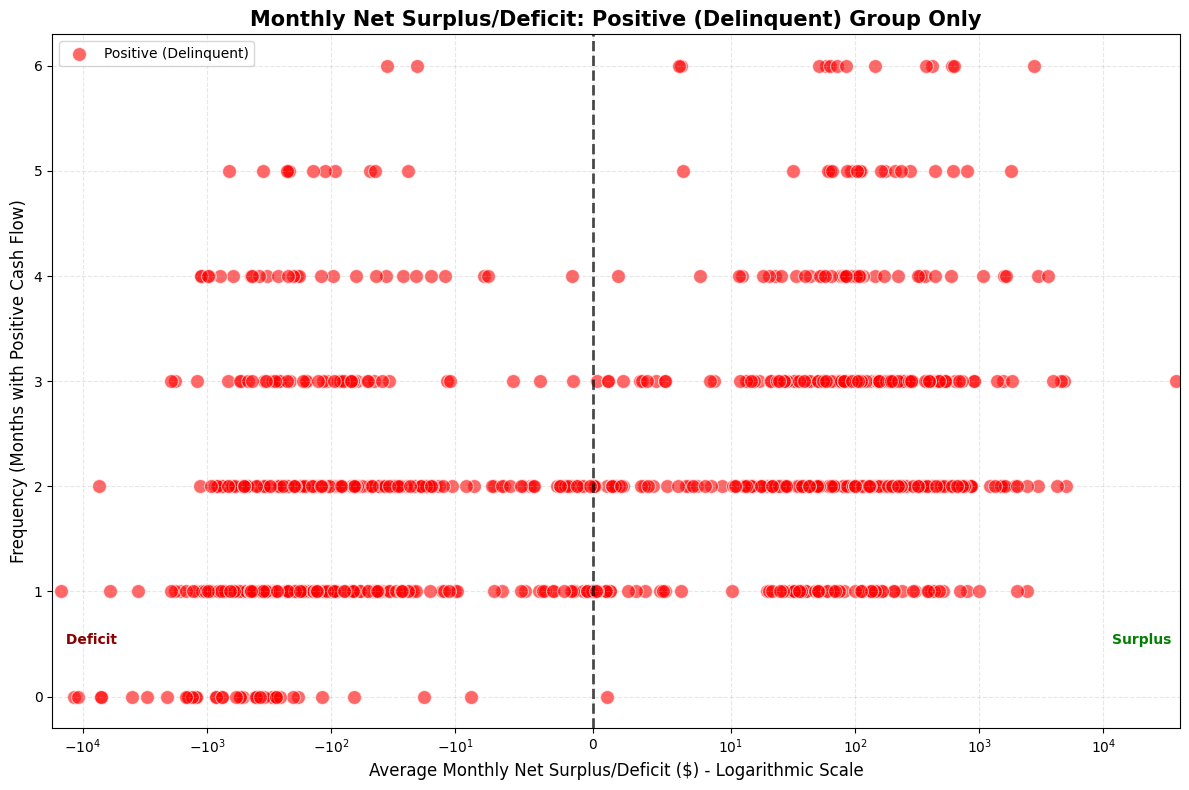

In [184]:


def analyze_full_cashflow(df, pos_list, neg_list):
    df = df.copy()
    df['posted_date'] = pd.to_datetime(df['posted_date'])
    df['year_month'] = df['posted_date'].dt.to_period('M')
    
    # 1. Calculate Monthly Net Cash Flow using signed_amount
    monthly_cashflow = df.groupby(['prism_consumer_id', 'year_month'])['signed_amount'].sum().reset_index()
    
    # 2. Aggregate per Consumer
    stats = monthly_cashflow.groupby('prism_consumer_id').agg(
        leftover_frequency=('signed_amount', lambda x: (x > 0).sum()),
        avg_net_amount=('signed_amount', 'mean') 
    ).reset_index()
    
    # Handle Net 0 to ensure visibility
    stats['avg_net_amount'] = stats['avg_net_amount'].apply(lambda x: x + 1 if x == 0 else x)
    
    # 3. Assign Target Labels
    stats['status'] = 'Other'
    stats.loc[stats['prism_consumer_id'].astype(str).isin(neg_list.astype(str)), 'status'] = 'Negative (Not Delinquent)'
    stats.loc[stats['prism_consumer_id'].astype(str).isin(pos_list.astype(str)), 'status'] = 'Positive (Delinquent)'
    
    # --- FILTERING STEP ---
    # Return only the Positive (Delinquent) group
    return stats[stats['status'] == 'Positive (Delinquent)']

# Generate metrics (now contains only the positive group)
cashflow_stats = analyze_full_cashflow(trxnDF, pos_list, neg_list)

# 4. Visualization
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=cashflow_stats,
    x='avg_net_amount',       
    y='leftover_frequency',   
    color='red',               # Set to a single color since we only have one group
    alpha=0.6,
    s=100,
    edgecolor='w',
    label='Positive (Delinquent)'
)

# --- Apply Symmetric Log Scale ---
# Using symlog in case some "Positive" users have a negative average net amount
plt.xscale('symlog', linthresh=10)

# Add a vertical line at 0 for reference
plt.axvline(0, color='black', linestyle='--', linewidth=2, alpha=0.7)

# Annotations
plt.text(cashflow_stats['avg_net_amount'].min(), 0.5, " Deficit", color='darkred', fontweight='bold')
plt.text(cashflow_stats['avg_net_amount'].max(), 0.5, "Surplus ", color='green', fontweight='bold', ha='right')

plt.title('Monthly Net Surplus/Deficit: Positive (Delinquent) Group Only', fontsize=15, fontweight='bold')
plt.xlabel('Average Monthly Net Surplus/Deficit ($) - Logarithmic Scale', fontsize=12)
plt.ylabel('Frequency (Months with Positive Cash Flow)', fontsize=12)
plt.grid(True, which="both", linestyle='--', alpha=0.3)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

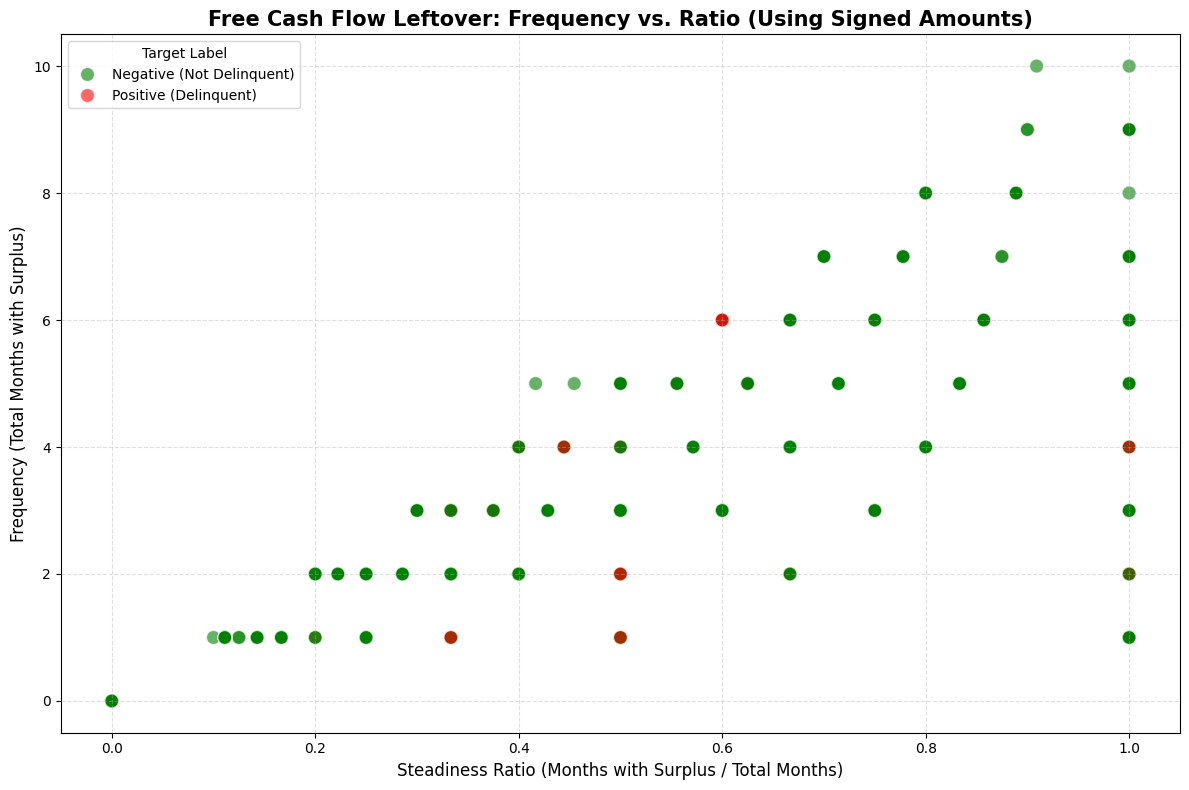

In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_cashflow_steadiness(df, pos_list, neg_list):
    # 1. Prepare Date and Month features
    df = df.copy()
    df['posted_date'] = pd.to_datetime(df['posted_date'])
    df['year_month'] = df['posted_date'].dt.to_period('M')
    
    # 2. Calculate Monthly Net Cash Flow per Consumer using signed_amount
    # Using 'signed_amount' ensures DEBITs subtract and CREDITs add correctly
    monthly_cashflow = df.groupby(['prism_consumer_id', 'year_month'])['signed_amount'].sum().reset_index()
    
    # 3. Define "Leftover" months (Net Cash Flow > 0)
    # This identifies months where the consumer ended with a surplus
    monthly_cashflow['has_leftover'] = monthly_cashflow['signed_amount'] > 0
    
    # 4. Aggregate metrics per Consumer
    # Horizon: Total unique months in the consumer's specific transaction history
    horizon = monthly_cashflow.groupby('prism_consumer_id')['year_month'].nunique()
    # Frequency: Total count of months where the net flow was positive
    frequency = monthly_cashflow[monthly_cashflow['has_leftover']].groupby('prism_consumer_id').size()
    
    # Combine into a features dataframe
    stats = pd.DataFrame({
        'horizon_months': horizon,
        'leftover_frequency': frequency
    }).fillna(0)
    
    # Ratio Metric: Proportion of months with a surplus
    stats['leftover_ratio'] = stats['leftover_frequency'] / stats['horizon_months']
    
    # 5. Assign Target Labels
    # Negative = Green (Not Delinquent), Positive = Red (Delinquent)
    stats['status'] = 'Other'
    stats.loc[stats.index.isin(neg_list.astype(str)), 'status'] = 'Negative (Not Delinquent)'
    stats.loc[stats.index.isin(pos_list.astype(str)), 'status'] = 'Positive (Delinquent)'
    
    return stats[stats['status'] != 'Other']

# Generate metrics using trxnDF
cashflow_stats = analyze_cashflow_steadiness(trxnDF, pos_list, neg_list)

# 6. Scatter Plot Visualization
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=cashflow_stats,
    x='leftover_ratio',
    y='leftover_frequency',
    hue='status',
    palette={'Negative (Not Delinquent)': 'green', 'Positive (Delinquent)': 'red'},
    alpha=0.6,
    s=100,
    edgecolor='w'
)

plt.title('Free Cash Flow Leftover: Frequency vs. Ratio (Using Signed Amounts)', fontsize=15, fontweight='bold')
plt.xlabel('Steadiness Ratio (Months with Surplus / Total Months)', fontsize=12)
plt.ylabel('Frequency (Total Months with Surplus)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title='Target Label', loc='upper left')

plt.tight_layout()
plt.show()

/var/folders/6r/152n25q91lzcqtjmm1gt04vc0000gn/T/ipykernel_48570/182003888.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history_df['posted_date'] = pd.to_datetime(history_df['posted_date'])
/var/folders/6r/152n25q91lzcqtjmm1gt04vc0000gn/T/ipykernel_48570/182003888.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['posted_date'] = pd.to_datetime(temp_df['posted_date'])


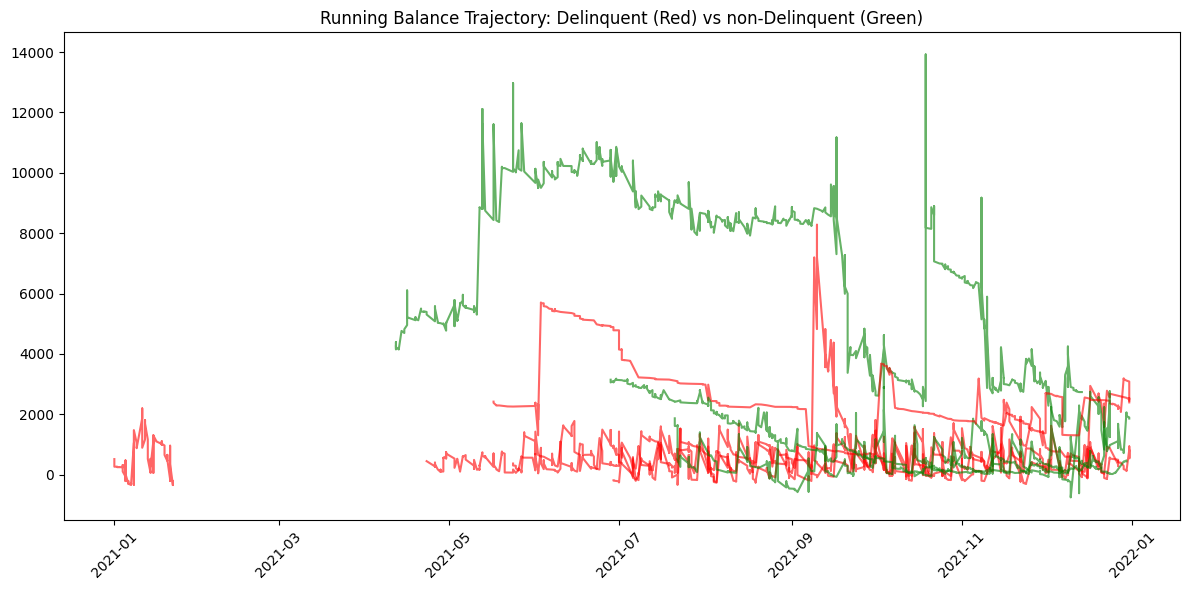

In [195]:
start_date = '2021-01-01'
end_date = '2021-12-31'

history_df['posted_date'] = pd.to_datetime(history_df['posted_date'])
mask = (history_df['posted_date'] >= start_date) & (history_df['posted_date'] <= end_date)
filtered_history = history_df.loc[mask].copy()

valid_ids = filtered_history['prism_consumer_id'].unique()
neg_list_filtered = [cid for cid in neg_list if cid in valid_ids]
pos_list_filtered = [cid for cid in pos_list if cid in valid_ids]

import random
sample_size = 5
sampled_neg = random.sample(neg_list_filtered, min(len(neg_list_filtered), sample_size))
sampled_pos = random.sample(pos_list_filtered, min(len(pos_list_filtered), sample_size))
target_ids = sampled_neg + sampled_pos

temp_df = filtered_history[filtered_history['prism_consumer_id'].isin(target_ids)]
temp_df['posted_date'] = pd.to_datetime(temp_df['posted_date'])

plt.figure(figsize=(12, 6))
for cid in temp_df['prism_consumer_id'].unique():
    subset = temp_df[temp_df['prism_consumer_id'] == cid].sort_values('posted_date')
    
    # Determine color
    if cid in neg_list:
        color, label_prefix = 'green', 'Non-Delinquent'
    elif cid in pos_list:
        color, label_prefix = 'red', 'Delinquent'
    else:
        color, label_prefix = 'gray', 'Unknown'
        
    plt.plot(subset['posted_date'], subset['running_balance'], linestyle='-', alpha=0.6, color=color)

plt.title('Running Balance Trajectory: Delinquent (Red) vs non-Delinquent (Green)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('balance_change.png')

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf

def classify_timeseries_periodic(group, freq='D'):
    """
    freq options: 
    'D'  : Daily
    'W'  : Weekly
    '2W' : Bi-weekly
    'ME' : Monthly (Month End)
    """
    periodic_series = group.set_index('posted_date')['running_balance'] \
                           .resample(freq).last().ffill()
    
    ts = periodic_series.diff().dropna()
    
    if len(ts) < 10:
        return pd.Series([0, 0], index=['is_AR', 'is_MA'])
    
    threshold = 1.96 / np.sqrt(len(ts))
    
    try:
        # Checking for signals at Lag 1
        acf_val = acf(ts, nlags=1, fft=False)[1]
        pacf_val = pacf(ts, nlags=1)[1]
    except:
        return pd.Series([0, 0], index=['is_AR', 'is_MA'])

    is_ma = 1 if abs(acf_val) > threshold else 0
    is_ar = 1 if abs(pacf_val) > threshold else 0
    
    return pd.Series([is_ar, is_ma], index=['is_AR', 'is_MA'])

In [222]:
frequencies = {
    'daily': 'D',
    'weekly': 'W',
    'biweekly': '2W',
    'monthly': 'ME'
}

output_df = consDF.copy()

for label, freq in frequencies.items():
    print(f"\n--- Processing Frequency: {label.upper()} ({freq}) ---")
    
    # 1. Generate features for this specific frequency
    features_df = history_df.groupby('prism_consumer_id').apply(
        classify_timeseries_periodic, freq=freq
    )
    
    # 2. Rename columns to avoid overwriting in the merge
    features_df = features_df.rename(columns={
        'is_AR': f'is_AR_{label}',
        'is_MA': f'is_MA_{label}'
    })
    
    # 3. Merge into the main dataframe
    output_df = output_df.merge(features_df, on='prism_consumer_id', how='left')
    
    # Fill NaNs for the new columns
    cols = [f'is_AR_{label}', f'is_MA_{label}']
    output_df[cols] = output_df[cols].fillna(0)
    
    # 4. Print normalized Value Counts for the Target
    print(f"[{label.upper()}] AR Signal vs Target Distribution:")
    print(output_df[output_df[f'is_AR_{label}'] >= 1]["DQ_TARGET"].value_counts(normalize=True))
    
    print(f"[{label.upper()}] MA Signal vs Target Distribution:")
    print(output_df[output_df[f'is_MA_{label}'] >= 1]["DQ_TARGET"].value_counts(normalize=True))
    print("-" * 50)

# Final result check
print("\nFinal DataFrame Columns:", output_df.columns.tolist())


--- Processing Frequency: DAILY (D) ---


/var/folders/6r/152n25q91lzcqtjmm1gt04vc0000gn/T/ipykernel_48570/1210912239.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features_df = history_df.groupby('prism_consumer_id').apply(


[DAILY] AR Signal vs Target Distribution:
DQ_TARGET
0.0    0.87443
1.0    0.12557
Name: proportion, dtype: float64
[DAILY] MA Signal vs Target Distribution:
DQ_TARGET
0.0    0.874552
1.0    0.125448
Name: proportion, dtype: float64
--------------------------------------------------

--- Processing Frequency: WEEKLY (W) ---


/var/folders/6r/152n25q91lzcqtjmm1gt04vc0000gn/T/ipykernel_48570/1210912239.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features_df = history_df.groupby('prism_consumer_id').apply(


[WEEKLY] AR Signal vs Target Distribution:
DQ_TARGET
0.0    0.925504
1.0    0.074496
Name: proportion, dtype: float64
[WEEKLY] MA Signal vs Target Distribution:
DQ_TARGET
0.0    0.931594
1.0    0.068406
Name: proportion, dtype: float64
--------------------------------------------------

--- Processing Frequency: BIWEEKLY (2W) ---


/var/folders/6r/152n25q91lzcqtjmm1gt04vc0000gn/T/ipykernel_48570/1210912239.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features_df = history_df.groupby('prism_consumer_id').apply(


[BIWEEKLY] AR Signal vs Target Distribution:
DQ_TARGET
0.0    0.949565
1.0    0.050435
Name: proportion, dtype: float64
[BIWEEKLY] MA Signal vs Target Distribution:
DQ_TARGET
0.0    0.949117
1.0    0.050883
Name: proportion, dtype: float64
--------------------------------------------------

--- Processing Frequency: MONTHLY (ME) ---
[MONTHLY] AR Signal vs Target Distribution:
DQ_TARGET
0.0    1.0
Name: proportion, dtype: float64
[MONTHLY] MA Signal vs Target Distribution:
DQ_TARGET
0.0    1.0
Name: proportion, dtype: float64
--------------------------------------------------

Final DataFrame Columns: ['prism_consumer_id', 'evaluation_date', 'DQ_TARGET', 'is_AR_daily', 'is_MA_daily', 'is_AR_weekly', 'is_MA_weekly', 'is_AR_biweekly', 'is_MA_biweekly', 'is_AR_monthly', 'is_MA_monthly']


/var/folders/6r/152n25q91lzcqtjmm1gt04vc0000gn/T/ipykernel_48570/1210912239.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features_df = history_df.groupby('prism_consumer_id').apply(


In [226]:
consDF["DQ_TARGET"].value_counts(normalize =True)

DQ_TARGET
0.0    0.916167
1.0    0.083833
Name: proportion, dtype: float64

      prism_consumer_id evaluation_date  DQ_TARGET
11173             11173      2022-01-05        0.0


,prism_consumer_id,posted_date,category,amount,credit_or_debit,running_balance
591667,11173,2021-05-03,24,38.83,DEBIT,3019.93
591668,11173,2021-05-03,24,31.25,DEBIT,2988.68
591669,11173,2021-05-03,17,27.75,DEBIT,2960.93
591670,11173,2021-05-03,17,22.16,DEBIT,2938.77
591671,11173,2021-05-03,17,16.06,DEBIT,2922.71
...,...,...,...,...,...,...
592697,11173,2022-01-04,16,9.80,DEBIT,1197.56
592698,11173,2022-01-04,14,10.08,DEBIT,1187.48
592699,11173,2022-01-04,18,65.33,DEBIT,1122.15
592700,11173,2022-01-04,39,29.99,DEBIT,1092.16


In [257]:
consDF[consDF["DQ_TARGET"] == 1]["prism_consumer_id"].sample(1).iloc[0]

'6260'

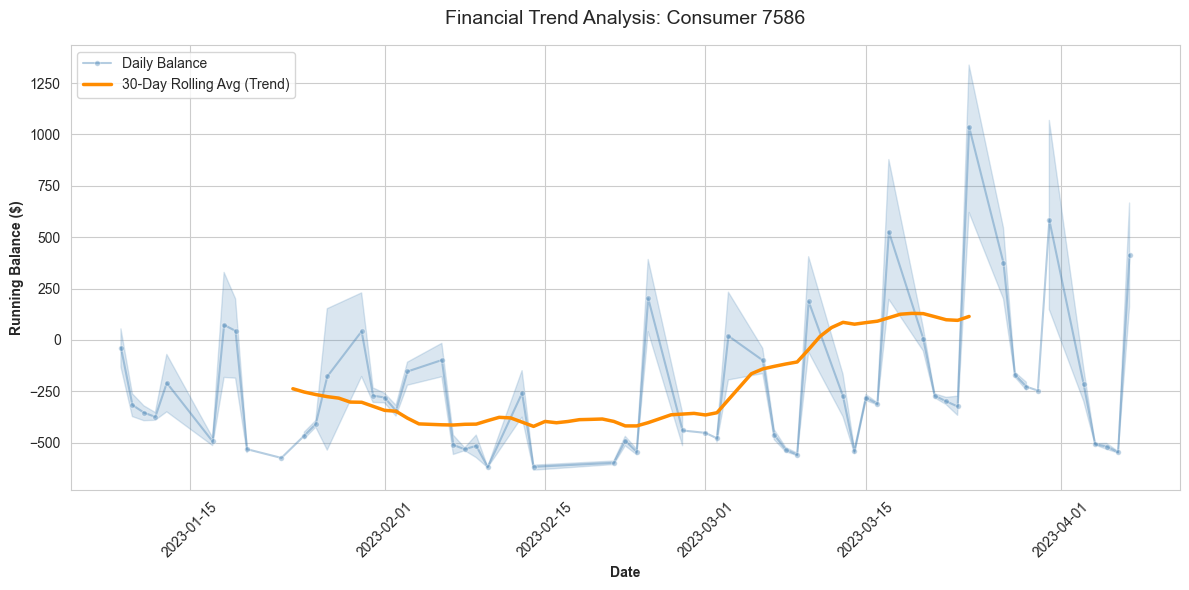

--- Metadata for Consumer 7586 ---


,prism_consumer_id,evaluation_date,DQ_TARGET
7586,7586,2023-04-07,1.0


,prism_consumer_id,posted_date,category,amount,credit_or_debit,running_balance
3614287,7586,2023-01-09,0,1.00,CREDIT,-31.73
3614307,7586,2023-01-09,20,11.75,DEBIT,-372.73
3614306,7586,2023-01-09,40,5.83,DEBIT,-360.98
3614305,7586,2023-01-09,40,9.75,DEBIT,-355.15
3614304,7586,2023-01-09,1,10.00,DEBIT,-345.40
...,...,...,...,...,...,...
3614869,7586,2023-04-07,3,1399.91,CREDIT,846.94
3614870,7586,2023-04-07,0,108.99,DEBIT,737.95
3614871,7586,2023-04-07,12,313.99,DEBIT,423.96
3614872,7586,2023-04-07,16,19.99,DEBIT,403.97


In [263]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

target_id = consDF[consDF["DQ_TARGET"] == 1]["prism_consumer_id"].sample(1).iloc[0] #history_df["prism_consumer_id"].sample(1).iloc[0]

user_data = history_df[history_df["prism_consumer_id"] == target_id].copy()
user_data['posted_date'] = pd.to_datetime(user_data['posted_date'])
user_data = user_data.sort_values('posted_date')

daily_series = user_data.set_index('posted_date')['running_balance'].resample('D').last().ffill()
trend = daily_series.rolling(window=30, center=True).mean()

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid") 

sns.lineplot(
    x=user_data['posted_date'], 
    y=user_data['running_balance'], 
    marker='o', 
    markersize=4, 
    alpha=0.4, 
    label='Daily Balance',
    color='steelblue'
)

plt.plot(trend.index, trend, color='darkorange', linewidth=2.5, label='30-Day Rolling Avg (Trend)')

plt.title(f'Financial Trend Analysis: Consumer {target_id}', fontsize=14, pad=15)
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Running Balance ($)', fontweight='bold')
plt.xticks(rotation=45)
plt.legend(frameon=True)
plt.tight_layout()
plt.show()

print(f"--- Metadata for Consumer {target_id} ---")
display(consDF[consDF["prism_consumer_id"] == target_id])
user_data

In [288]:
import numpy as np
from sklearn.linear_model import LinearRegression

def get_trend_slope(group):
    series = group.set_index('posted_date')['running_balance'].resample('D').last().ffill().dropna()
    if len(series) < 2:
        return 0
    
    y = series.values
    X = np.arange(len(y)).reshape(-1, 1)
    
    model = LinearRegression().fit(X, y)
    return model.coef_[0]

history_df['posted_date'] = pd.to_datetime(history_df['posted_date'])
slopes = history_df.groupby('prism_consumer_id').apply(get_trend_slope)
k = {}
for j,i in enumerate(range(-100,100,10)):
    threshold = i

    significant_decline_ids = slopes[slopes < threshold].index.tolist()
    significant_decline_df = slopes[slopes < threshold].sort_values()

    k[j] = consDF[consDF["prism_consumer_id"].isin(significant_decline_ids)]["DQ_TARGET"].value_counts()

/var/folders/6r/152n25q91lzcqtjmm1gt04vc0000gn/T/ipykernel_48570/4279951395.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history_df['posted_date'] = pd.to_datetime(history_df['posted_date'])
/var/folders/6r/152n25q91lzcqtjmm1gt04vc0000gn/T/ipykernel_48570/4279951395.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slopes = history_df.groupby('prism_consumer_id').apply(get_trend_slope)


In [289]:
k

{0: DQ_TARGET
 0.0    208
 1.0     13
 Name: count, dtype: int64,
 1: DQ_TARGET
 0.0    226
 1.0     15
 Name: count, dtype: int64,
 2: DQ_TARGET
 0.0    260
 1.0     18
 Name: count, dtype: int64,
 3: DQ_TARGET
 0.0    312
 1.0     21
 Name: count, dtype: int64,
 4: DQ_TARGET
 0.0    368
 1.0     23
 Name: count, dtype: int64,
 5: DQ_TARGET
 0.0    459
 1.0     30
 Name: count, dtype: int64,
 6: DQ_TARGET
 0.0    582
 1.0     42
 Name: count, dtype: int64,
 7: DQ_TARGET
 0.0    746
 1.0     57
 Name: count, dtype: int64,
 8: DQ_TARGET
 0.0    1049
 1.0      78
 Name: count, dtype: int64,
 9: DQ_TARGET
 0.0    1665
 1.0     138
 Name: count, dtype: int64,
 10: DQ_TARGET
 0.0    3906
 1.0     430
 Name: count, dtype: int64,
 11: DQ_TARGET
 0.0    6809
 1.0     746
 Name: count, dtype: int64,
 12: DQ_TARGET
 0.0    7571
 1.0     805
 Name: count, dtype: int64,
 13: DQ_TARGET
 0.0    7968
 1.0     826
 Name: count, dtype: int64,
 14: DQ_TARGET
 0.0    8195
 1.0     832
 Name: count, dtype

In [310]:
def get_trend_slope(group):
    series = group.set_index('posted_date')['running_balance'].resample('D').last().ffill().dropna()
    if len(series) < 2:
        return 0
    
    y = series.values
    X = np.arange(len(y)).reshape(-1, 1)
    
    model = LinearRegression().fit(X, y)
    return model.coef_[0]

A = history_df.groupby('prism_consumer_id').apply(get_trend_slope)


/var/folders/6r/152n25q91lzcqtjmm1gt04vc0000gn/T/ipykernel_48570/4201530259.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  A = history_df.groupby('prism_consumer_id').apply(get_trend_slope)


In [311]:
A = A.reset_index()

In [312]:
temp_df = consDF.copy()


In [313]:
temp_df = temp_df.merge(A, on = "prism_consumer_id", how = "left")


In [ ]:
filler = temp_df[0].mean()
temp_df[0] = temp_df[0].fillna(filler)
temp_df['trend'] =  temp_df[0]


,prism_consumer_id,evaluation_date,DQ_TARGET,trend
0,0,2021-09-01,0.0,-14.922414
1,1,2021-07-01,0.0,19.715780
2,2,2021-05-01,0.0,30.072240
3,3,2021-03-01,0.0,7.804348
4,4,2021-10-01,0.0,4.026059
...,...,...,...,...
11995,13995,2022-01-22,0.0,3.823212
11996,13996,2022-02-01,0.0,16.595677
11997,13997,2021-12-24,0.0,0.163170
11998,13998,2022-01-30,0.0,35.686132


In [319]:
temp_df = temp_df.drop(columns= [0])

In [322]:
temp_df[temp_df["DQ_TARGET"] == 1]['trend'].describe()

count    1006.000000
mean       -2.886374
std        63.307267
min      -883.471577
25%        -3.124080
50%         0.604531
75%         4.026059
max       615.961552
Name: trend, dtype: float64

In [323]:
temp_df[temp_df["DQ_TARGET"] == 0]['trend'].describe()

count    10994.000000
mean         4.658578
std        433.993922
min     -35012.490000
25%         -2.944090
50%          2.872493
75%          6.198369
max      22554.702381
Name: trend, dtype: float64